# CAES Dataset Notebook
## 4. Data Analysis

Tests related to the CAES essay dataset.

### Load dataset

In [23]:
import pandas as pd

df = pd.read_csv("caes/cleaned_caes.csv")
print("Shape:", df.shape)
df

Shape: (26653, 5)


,essay_id,full_text,score,word_count,prompt_name
0,0,hola carlos ! hace mucho que no te veo hombre ...,B1,212,Carta amigo
1,1,"hola querida sara , espero que estes muy bien ...",A2,175,Carta amigo
2,2,como estais ? ! hola amigos ! ? espero que tod...,A1,104,Postal vacaciones
3,3,"cuando llegué a el destino , le propuso que si...",A2,135,Postal vacaciones
4,4,¿ que tal ? un beso espero que todo va bien po...,A1,80,Familia
...,...,...,...,...,...
26648,26648,buenas tardes ! 29_de_mayo_de_2019 salamanca q...,B1,299,Carta amigo
26649,26649,tengo la seguridad de mí mismo para contener e...,B2,157,Solicitud admisión
26650,26650,"distinguidos señor / señra : hola , gerente . ...",B1,178,Reclamación compañía aérea
26651,26651,le escribo esta carta porque me gustaría inmen...,B2,303,Solicitud admisión


In [24]:
print("Column names:", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

Column names: ['essay_id', 'full_text', 'score', 'word_count', 'prompt_name']

Data types:
 essay_id        int64
full_text      object
score          object
word_count      int64
prompt_name    object
dtype: object

Missing values:
 essay_id       0
full_text      0
score          0
word_count     0
prompt_name    0
dtype: int64


In [25]:
df[["word_count"]].describe()

,word_count
count,26653.000000
mean,185.708025
std,84.704274
min,80.000000
25%,123.000000
50%,164.000000
75%,227.000000
max,771.000000


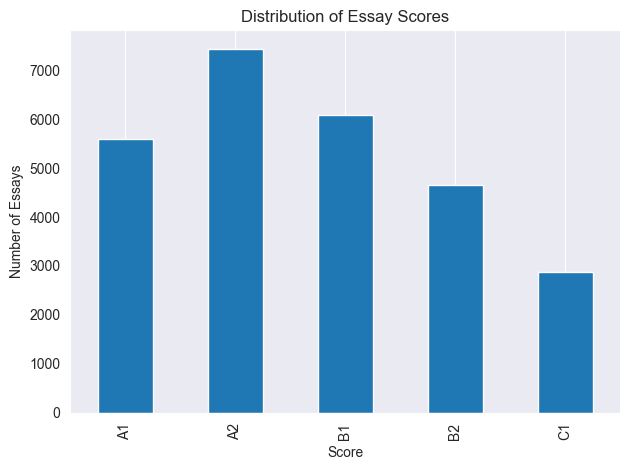

In [26]:
import matplotlib.pyplot as plt

df["score"].value_counts().sort_index().plot(kind='bar')
plt.title("Distribution of Essay Scores")
plt.xlabel("Score")
plt.ylabel("Number of Essays")
plt.grid(axis="y")
plt.tight_layout()

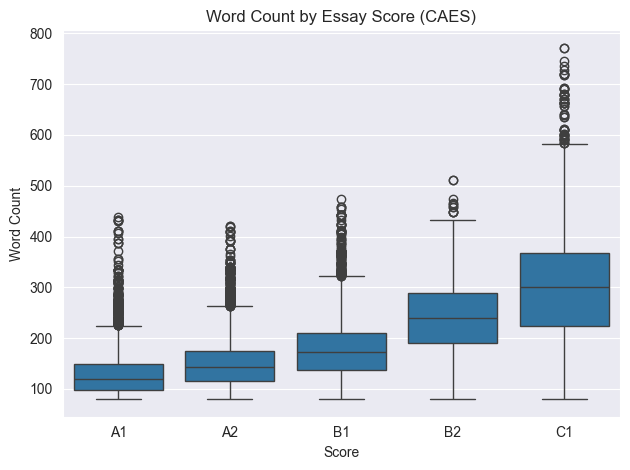

In [33]:
import seaborn as sns

# define order
order = ["A1","A2","B1","B2","C1"]
df["score"] = pd.Categorical(df["score"], categories=order, ordered=True)

# plot
sns.boxplot(data=df, x="score", y="word_count")
plt.title("Word Count by Essay Score (CAES)")
plt.xlabel("Score")
plt.ylabel("Word Count")
plt.tight_layout()

In [37]:
df.groupby("score")["word_count"].agg(['count','mean','median','std'])

/var/folders/4n/slwln6451ql9kp_wwdcstgf00000gn/T/ipykernel_15988/3238444863.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("score")["word_count"].agg(['count','mean','median','std'])


,count,mean,median,std
score,,,,
A1,5599,130.937846,119.0,45.547215
A2,7440,151.941801,143.0,50.012279
B1,6079,178.462905,173.0,57.701849
B2,4658,240.350580,239.0,69.142278
C1,2877,306.457769,301.0,113.500011


### Scored Dataset

####  QWK Calculation

In [7]:
import glob
import os
import pandas as pd
from sklearn.metrics import cohen_kappa_score

# map from CEFR level to numbers between 1 and 6
CEFR_MAP = {
    "A1": 1,
    "A2": 2,
    "B1": 3,
    "B2": 4,
    "C1": 5,
    "C2": 6
}

def compute_qwk(df, mode="both"):
    # drop any nulls
    df = df.dropna(subset=["score_og", "score_llm"]).copy()

    # map CEFR strings -> ints
    df["og_num"]  = df["score_og"].map(CEFR_MAP)
    df["llm_num"] = df["score_llm"].map(CEFR_MAP)

    # select originals or CFs or both
    if mode == "OR":
        sel = df[df["essay_code"].str.endswith("-O")]
    elif mode == "CF":
        sel = df[df["essay_code"].str.contains("-C")]
    else:
        sel = df
    return cohen_kappa_score(sel["og_num"], sel["llm_num"], weights="quadratic")

# load all CAES counterfactual CSVs
BASE = "counterfactuals_scored/caes"
models = {}
for model_name in os.listdir(BASE):
    model_dir = os.path.join(BASE, model_name)
    if not os.path.isdir(model_dir):
        continue

    paths = glob.glob(os.path.join(model_dir, "*_scored.csv"))
    if not paths:
        print(f"no files for {model_name}, skipping")
        continue

    df_all = pd.concat([pd.read_csv(p) for p in paths], ignore_index=True)
    models[model_name] = df_all

# compute & print CEFR‐mapped QWKs
for name, df in models.items():
    q_or   = compute_qwk(df, "OR")
    q_cf   = compute_qwk(df, "CF")
    q_both = compute_qwk(df, "both")
    print(f"\n=== QWK for {name} ===")
    print(f" originals: {q_or:.4f}")
    print(f" counterfactuals: {q_cf:.4f}")
    print(f" diff: {q_or - q_cf:.4f}")
    print(f" combined: {q_both:.4f}")


=== QWK for llama3 ===
 originals: 0.0000
 counterfactuals: 0.0000
 diff: 0.0000
 combined: 0.0000

=== QWK for gemma3 ===
 originals: 0.5768
 counterfactuals: 0.6002
 diff: -0.0234
 combined: 0.5887

=== QWK for qwen3 ===
 originals: 0.3027
 counterfactuals: 0.3280
 diff: -0.0253
 combined: 0.3158

=== QWK for deepseek ===
 originals: 0.1006
 counterfactuals: 0.1226
 diff: -0.0221
 combined: 0.1115


### JS distance

In [10]:
import glob
import os
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon

# map from CEFR level to numbers between 1 and 6
CEFR_MAP = {
    "A1": 1,
    "A2": 2,
    "B1": 3,
    "B2": 4,
    "C1": 5,
    "C2": 6
}

def compute_js(df, score_col='score_llm', code_col='essay_code'):
    df = df.dropna(subset=[score_col]).copy()
    # create version column depending on whether it has -O or -CFO (else)
    df['version'] = np.where(
        df[code_col].str.endswith('-O'),
        'OR',
        'CF'
    )

    # count vectors
    bins = sorted(df[score_col].unique())
    og_counts = df[df['version']=='OR'][score_col].value_counts().reindex(bins, fill_value=0)
    cf_counts = df[df['version']=='CF'][score_col].value_counts().reindex(bins, fill_value=0)

    P = og_counts.values / og_counts.sum()
    Q = cf_counts.values / cf_counts.sum()

    dist = jensenshannon(P, Q, base=2)
    div = dist**2

    return dist, div

BASE = "counterfactuals_scored/caes"
models = {}
for model_name in os.listdir(BASE):
    model_dir = os.path.join(BASE, model_name)
    if not os.path.isdir(model_dir):
        continue

    paths = glob.glob(os.path.join(model_dir, "*_scored.csv"))
    if not paths:
        print(f"no files for {model_name}, skipping")
        continue

    dfs = [pd.read_csv(p) for p in paths]
    df_all = pd.concat(dfs, ignore_index=True)
    models[model_name] = df_all

for name, df in models.items():
    js_dist, js_div = compute_js(df, score_col='score_llm')

    print(f"\n=== {name} ===")
    print(f"JS distance (OR vs CF):   {js_dist:.4f}")
    print(f"JS divergence (OR vs CF):  {js_div:.4f}")


=== llama3 ===
JS distance (OR vs CF):   0.0000
JS divergence (OR vs CF):  0.0000

=== gemma3 ===
JS distance (OR vs CF):   0.0617
JS divergence (OR vs CF):  0.0038

=== qwen3 ===
JS distance (OR vs CF):   0.0900
JS divergence (OR vs CF):  0.0081

=== deepseek ===
JS distance (OR vs CF):   0.0907
JS divergence (OR vs CF):  0.0082


### QWK and JS distance per flip per model

In [13]:
import glob, os
import numpy as np
import pandas as pd
from sklearn.metrics import cohen_kappa_score
from scipy.spatial import distance

BASE = "counterfactuals_scored/caes"

def extract_direction_from_path(path):
    fname = os.path.basename(path)
    return fname.replace("_scored.csv", "")

def load_model_dfs(base):
    models = {}
    for model in os.listdir(base):
        d = os.path.join(base, model)
        if not os.path.isdir(d): continue
        parts = []
        for csvf in glob.glob(os.path.join(d, "*_scored.csv")):
            df = pd.read_csv(csvf)
            df["direction"] = extract_direction_from_path(csvf)
            parts.append(df)
        if parts:
            models[model] = pd.concat(parts, ignore_index=True)
    return models

def qwk_for_flip(df, flip):
    sub = df[df["direction"] == flip].dropna(subset=["score_og_num","score_llm_num"])
    orig = sub[sub["essay_code"].str.endswith("-O")]
    cf   = sub[sub["essay_code"].str.contains("-C")]
    return (
        cohen_kappa_score(orig["score_og_num"], orig["score_llm_num"], weights="quadratic"),
        cohen_kappa_score(cf["score_og_num"],   cf["score_llm_num"],   weights="quadratic"),
        cohen_kappa_score(sub["score_og_num"],   sub["score_llm_num"],   weights="quadratic"),
    )

def js_for_flip(df, flip):
    sub = df[df["direction"] == flip].dropna(subset=["score_llm_num"])
    support = sorted(sub["score_llm_num"].astype(int).unique())
    def hist(srs):
        cnt = np.bincount(srs.astype(int), minlength=max(support)+1)[support]
        return cnt / cnt.sum()
    p_or = hist(sub[sub["essay_code"].str.endswith("-O")]["score_llm_num"])
    p_cf = hist(sub[sub["essay_code"].str.contains("-C")]["score_llm_num"])
    jsd  = distance.jensenshannon(p_or, p_cf)
    return jsd, jsd**2

# load everything
models = load_model_dfs(BASE)

# map
CEFR_MAP = {
    "A1": 1,
    "A2": 2,
    "B1": 3,
    "B2": 4,
    "C1": 5,
    "C2": 6
}

# map both score types
for model_name, df in models.items():
    df["score_og_num"]  = df["score_og"].map(CEFR_MAP)
    df["score_llm_num"] = df["score_llm"].map(CEFR_MAP)

    print(f"\n=== Model: {model_name} ===")
    for flip in sorted(df["direction"].unique()):
        q_or, q_cf, q_both = qwk_for_flip(df, flip)
        jsd, js2   = js_for_flip(df, flip)
        print(f"{flip:30s}  QWK(OR)={q_or:.3f}  QWK(CF)={q_cf:.3f}  QWK(both)={q_both:.3f}  Δ={q_or-q_cf:.3f}  "
              f"JSdist={jsd:.3f}  JSdiv={js2:.4f}")


=== Model: llama3 ===
formality_formal_to_informal    QWK(OR)=0.000  QWK(CF)=0.000  QWK(both)=0.000  Δ=0.000  JSdist=0.000  JSdiv=0.0000
formality_informal_to_formal    QWK(OR)=0.000  QWK(CF)=0.000  QWK(both)=0.000  Δ=0.000  JSdist=0.000  JSdiv=0.0000
sentiment_negative_to_positive  QWK(OR)=0.000  QWK(CF)=0.000  QWK(both)=0.000  Δ=0.000  JSdist=0.000  JSdiv=0.0000
sentiment_positive_to_negative  QWK(OR)=0.000  QWK(CF)=0.000  QWK(both)=0.000  Δ=0.000  JSdist=0.000  JSdiv=0.0000
stance_con_to_pro               QWK(OR)=0.000  QWK(CF)=0.000  QWK(both)=0.000  Δ=0.000  JSdist=0.000  JSdiv=0.0000
stance_pro_to_con               QWK(OR)=0.000  QWK(CF)=0.000  QWK(both)=0.000  Δ=0.000  JSdist=0.000  JSdiv=0.0000

=== Model: gemma3 ===
formality_formal_to_informal    QWK(OR)=0.543  QWK(CF)=0.308  QWK(both)=0.427  Δ=0.234  JSdist=0.185  JSdiv=0.0343
formality_informal_to_formal    QWK(OR)=0.551  QWK(CF)=0.738  QWK(both)=0.650  Δ=-0.187  JSdist=0.195  JSdiv=0.0379
sentiment_negative_to_positive  Q

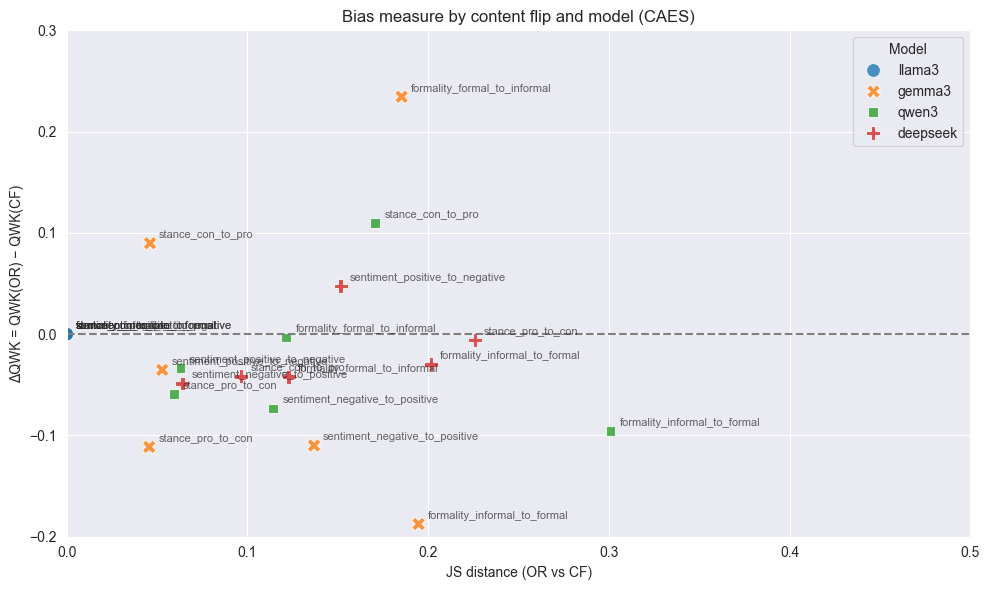

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assemble a flat DataFrame with one row per (model, flip)
records = []
for model_name, df in models.items():
    for flip in sorted(df["direction"].unique()):
        q_or, q_cf, q_both = qwk_for_flip(df, flip)
        jsd, js2 = js_for_flip(df, flip)
        records.append({
            "model": model_name,
            "flip":  flip,
            "ΔQWK":  q_or - q_cf,
            "JSdist": jsd
        })
plot_df = pd.DataFrame(records)

# Plot
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=plot_df,
    x="JSdist", y="ΔQWK",
    hue="model",
    style="model",
    s=100,
    alpha=0.8
)

# annotate each point with its flip name
for _, row in plot_df.iterrows():
    plt.text(
        row["JSdist"] + 0.005,
        row["ΔQWK"] + 0.005,
        row["flip"],
        fontsize=8,
        alpha=0.7
    )

plt.xlim(0.0, 0.5)
plt.ylim(-0.2, 0.3)

plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0, color="gray", linestyle="--")
plt.xlabel("JS distance (OR vs CF)")
plt.ylabel("ΔQWK = QWK(OR) − QWK(CF)")
plt.title("Bias measure by content flip and model (CAES)")
plt.legend(title="Model")
plt.tight_layout()